In [1]:
import cudf
import cupy as cp
from cuml.cluster import DBSCAN
import matplotlib.pyplot as plt
from cuml.preprocessing import StandardScaler

# 1. Load data to GPU
gdf = cudf.read_csv('/kaggle/input/final-earthquake-data-2002-2025/final_earthquake_data_2002_2025.csv')

# 2. Sample 100%
gdf_sample = gdf.sample(frac=1, random_state=42)

# 3. Clean and Normalize
gdf_data = gdf_sample[['Latitude', 'Longitude']].dropna()
data_matrix = gdf_data.astype('float32')

scaler = StandardScaler()
X_scaled_gpu = scaler.fit_transform(data_matrix)

# Keep CPU version for plotting
X_original_cpu = gdf_data.to_pandas()
n_rows = len(gdf_data)

print(f"Total samples for clustering: {n_rows}")
print("Data normalized on GPU.")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


Total samples for clustering: 2921770
Data normalized on GPU.


Running DBSCAN with Eps=0.15, Min_Samples=1460...
[2026-01-04 18:43:42.017] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 864 -> 734. Using the larger integer type might result in better performance


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


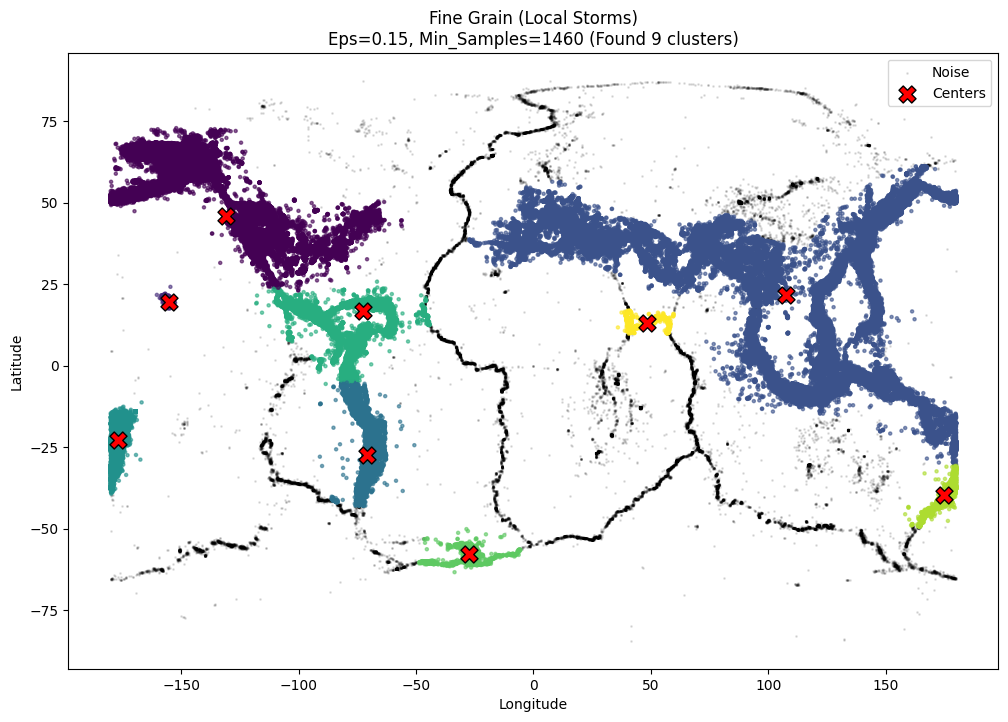

In [2]:
# Parameters for detailed local clusters
eps_val = 0.15  # Small radius (tight density)
ratio = 0.0005  # 0.05% of dataset size
min_samples_val = int(n_rows * ratio) 

print(f"Running DBSCAN with Eps={eps_val}, Min_Samples={min_samples_val}...")

# 1. Run DBSCAN (GPU)
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_gpu = db.fit_predict(X_scaled_gpu)
labels = labels_gpu.to_numpy()

# 2. Prepare Plot Data
temp_df = X_original_cpu.copy()
temp_df['label'] = labels

# Filter noise
cluster_data = temp_df[temp_df['label'] != -1]
noise_data = temp_df[temp_df['label'] == -1]

# Calculate Centroids
if len(cluster_data) > 0:
    centroids = cluster_data.groupby('label').mean().values
else:
    centroids = []

# 3. Plot
plt.figure(figsize=(12, 8))
# Plot noise smaller and lighter
plt.scatter(noise_data['Longitude'], noise_data['Latitude'], c='black', s=1, alpha=0.1, label='Noise')
# Plot clusters
plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], c=cluster_data['label'], cmap='viridis', s=5, alpha=0.6)
# Plot centroids
if len(centroids) > 0:
    plt.scatter(centroids[:, 1], centroids[:, 0], c='red', edgecolors='black', s=150, marker='X', label='Centers')

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
plt.title(f'Fine Grain (Local Storms)\nEps={eps_val}, Min_Samples={min_samples_val} (Found {n_clusters} clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

Running DBSCAN with Eps=0.3, Min_Samples=2921...
[2026-01-04 21:02:34.195] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 864 -> 734. Using the larger integer type might result in better performance


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


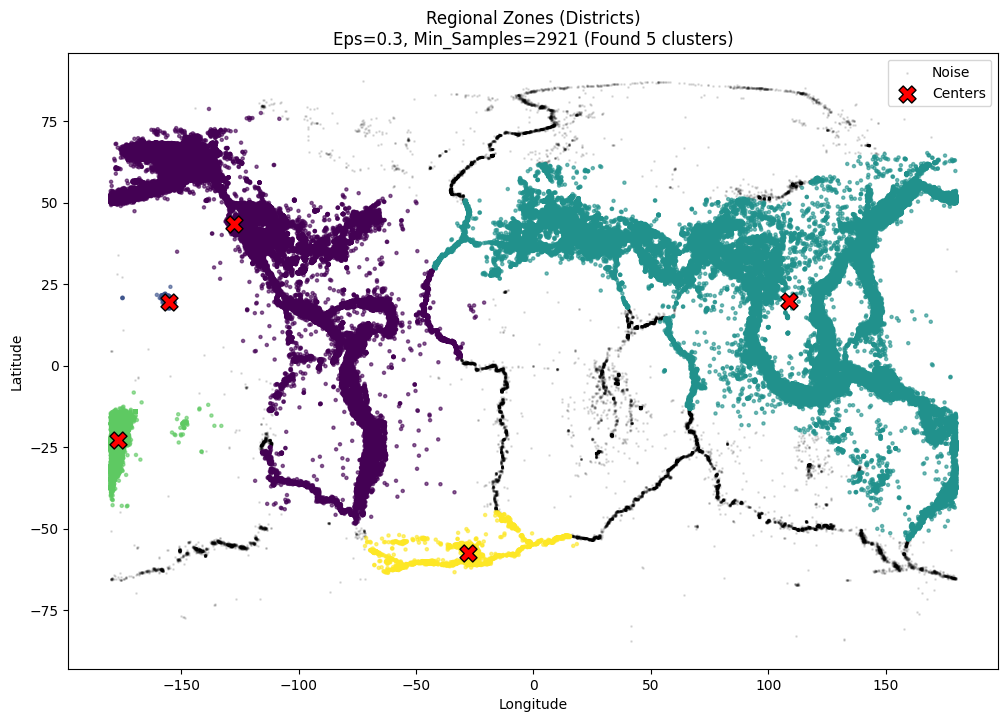

In [3]:
# Parameters for regional clusters
eps_val = 0.3   # Medium radius
ratio = 0.001   # 0.1% of dataset size
min_samples_val = int(n_rows * ratio)

print(f"Running DBSCAN with Eps={eps_val}, Min_Samples={min_samples_val}...")

db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_gpu = db.fit_predict(X_scaled_gpu)
labels = labels_gpu.to_numpy()

temp_df = X_original_cpu.copy()
temp_df['label'] = labels
cluster_data = temp_df[temp_df['label'] != -1]
noise_data = temp_df[temp_df['label'] == -1]

if len(cluster_data) > 0:
    centroids = cluster_data.groupby('label').mean().values
else:
    centroids = []

plt.figure(figsize=(12, 8))
plt.scatter(noise_data['Longitude'], noise_data['Latitude'], c='black', s=1, alpha=0.1, label='Noise')
plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], c=cluster_data['label'], cmap='viridis', s=5, alpha=0.6)
if len(centroids) > 0:
    plt.scatter(centroids[:, 1], centroids[:, 0], c='red', edgecolors='black', s=150, marker='X', label='Centers')

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
plt.title(f'Regional Zones (Districts)\nEps={eps_val}, Min_Samples={min_samples_val} (Found {n_clusters} clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

Running DBSCAN with Eps=0.5, Min_Samples=14608...
[2026-01-04 23:47:40.314] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 864 -> 734. Using the larger integer type might result in better performance


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


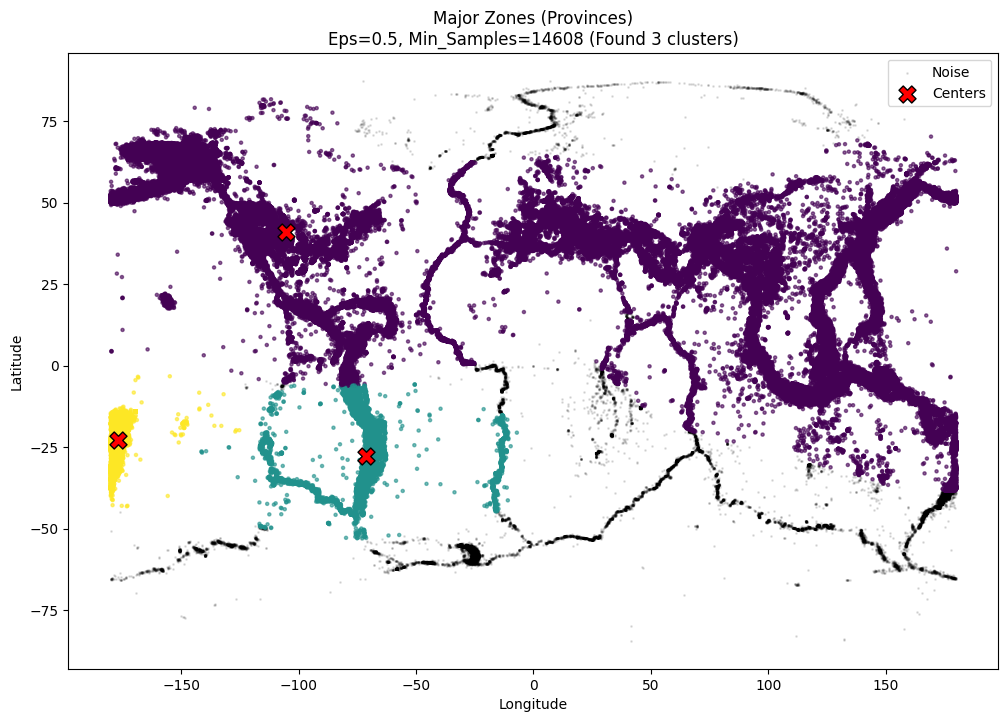

In [4]:
# Parameters for major zones
eps_val = 0.5   # Large radius
ratio = 0.005   # 0.5% of dataset size
min_samples_val = int(n_rows * ratio)

print(f"Running DBSCAN with Eps={eps_val}, Min_Samples={min_samples_val}...")

db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_gpu = db.fit_predict(X_scaled_gpu)
labels = labels_gpu.to_numpy()

temp_df = X_original_cpu.copy()
temp_df['label'] = labels
cluster_data = temp_df[temp_df['label'] != -1]
noise_data = temp_df[temp_df['label'] == -1]

if len(cluster_data) > 0:
    centroids = cluster_data.groupby('label').mean().values
else:
    centroids = []

plt.figure(figsize=(12, 8))
plt.scatter(noise_data['Longitude'], noise_data['Latitude'], c='black', s=1, alpha=0.1, label='Noise')
plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], c=cluster_data['label'], cmap='viridis', s=5, alpha=0.6)
if len(centroids) > 0:
    plt.scatter(centroids[:, 1], centroids[:, 0], c='red', edgecolors='black', s=150, marker='X', label='Centers')

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
plt.title(f'Major Zones (Provinces)\nEps={eps_val}, Min_Samples={min_samples_val} (Found {n_clusters} clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()